In [9]:
from jax.config import config
config.update("jax_enable_x64", True)

import jax.numpy as jnp
import numpy as np
import pickle
from jax import jit, vmap, grad
import jax.random as random
rng = random.PRNGKey(2022)
import jax.example_libraries.optimizers as optimizers
from jax.flatten_util import ravel_pytree

import matplotlib.pyplot as plt
import pandas as pd

from utils import train, eval_Cauchy_aniso, eval_Cauchy_aniso_vmap, plotmesh, merge_weights_aniso

import GPy
from jaxinterp2d import interp2d

Reaction forces in x & y: 0.9355329412894062 0.6441521954876857


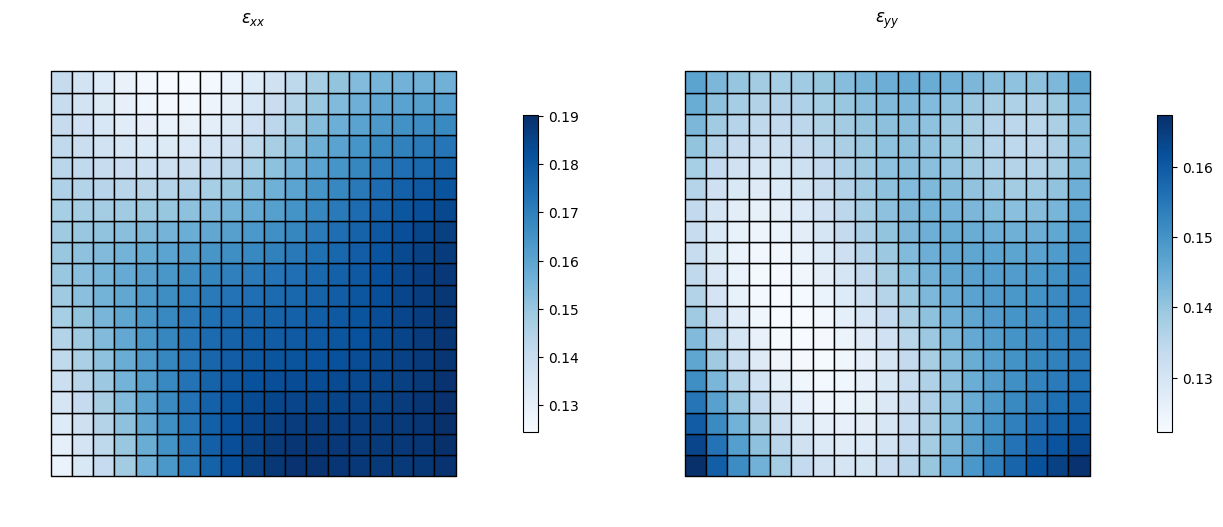

In [10]:
# Generate a synthetic heterogeneous field and assume some boundary conditions
nvar = 2
nrow = 20
ncol = 20
n_node = nrow*ncol
n_elem = n_node-nrow-ncol+1
pts_x = np.linspace(0,1,nrow)
pts_y = np.linspace(0,1,ncol)
node_X, node_Y = np.meshgrid(pts_x,pts_y)
node_X = np.vstack((node_Y.flatten(), node_X.flatten())).T

# Identify the boundary nodes
rgt_bd = np.where(node_X[:,0]>0.99)
top_bd = np.where(node_X[:,1]>0.99)
lft_bd = np.where(node_X[:,0]<0.01)
bot_bd = np.where(node_X[:,1]<0.01)
rgt_bd_x = node_X[rgt_bd,0].flatten()
rgt_bd_y = node_X[rgt_bd,1].flatten()
top_bd_x = node_X[top_bd,0].flatten()
top_bd_y = node_X[top_bd,1].flatten()
lft_bd_x = node_X[lft_bd,0].flatten()
lft_bd_y = node_X[lft_bd,1].flatten()
bot_bd_x = node_X[bot_bd,0].flatten()
bot_bd_y = node_X[bot_bd,1].flatten()

elements = np.zeros((n_elem, 4), dtype=np.int_)

i=0
j=0
while i < n_node - ncol: #exclude 1 row at the top because there are no nodes above those to form elements.
    if (i+1)%ncol != 0: #Skip the nodes on the right
        elements[j,0] = i
        elements[j,3] = i+1
        elements[j,2] = i+ncol + 1
        elements[j,1] = i+ncol
        j+= 1
    i+= 1

k = GPy.kern.RBF(input_dim=2,lengthscale=0.4)
mu = np.zeros((node_X.shape[0]))
C = k.K(node_X,node_X)

strains = -1
while np.any(strains<0.1) or np.any(strains>0.2):
    strains = np.random.multivariate_normal(mu,C,nvar)*0.03+0.15 #I want the strains to be between 0.1 and 0.2

fig, axes = plt.subplots(1,2,figsize=(15,7))
for i in range(nvar):
    eps = strains[i]
    ax = axes[i]
    title = ['$\epsilon_{xx}$', '$\epsilon_{yy}$'][i]
    c_elem = 0.25*(eps[elements[:,0]] + eps[elements[:,1]] + eps[elements[:,2]] + eps[elements[:,3]])
    plotmesh(elements, node_X, c_elem, title=title, ax=ax); 


# Boundary conditions
# Assume some random values around 1
Fx, Fy = np.random.uniform(size=2)+0.5
print('Reaction forces in x & y:', Fx, Fy)

In [11]:
# GOH Material model
class GOH():
    def __init__(self, params):
        C10, k1, k2, kappa = params
        self.C10 = jnp.exp(C10)
        self.k1  = jnp.exp(k1)
        self.k2  = jnp.exp(k2)
        self.kappa = jnp.exp(kappa)

        self.theta = 0.0

    def Psi1(self, I1, I2, Iv, Iw):
        C10, k1, k2, kappa = self.C10, self.k1, self.k2, self.kappa
        E_alphav = kappa*(I1-3.0) + (1-3*kappa)*(Iv-1.0)
        E_alphav = jnp.maximum(E_alphav, 0.0)

        E_alphaw = kappa*(I1-3.0) + (1-3*kappa)*(Iw-1.0)
        E_alphaw = jnp.maximum(E_alphaw, 0.0)
        return C10 + k1*kappa*E_alphav*jnp.exp(k2*E_alphav**2) \
                   + k1*kappa*E_alphaw*jnp.exp(k2*E_alphaw**2)

    def Psiv(self, I1, I2, Iv, Iw):
        C10, k1, k2, kappa = self.C10, self.k1, self.k2, self.kappa
        E_alphav = kappa*(I1-3.0) + (1-3*kappa)*(Iv-1.0)
        E_alphav = jnp.maximum(E_alphav, 0.0)
        return k1*(1-3*kappa)*E_alphav*jnp.exp(k2*E_alphav**2)
    
    def Psi2(self, I1, I2, Iv, Iw):
        return 0.0
    
    def Psiw(self, I1, I2, Iv, Iw):
        C10, k1, k2, kappa = self.C10, self.k1, self.k2, self.kappa
        E_alphaw = kappa*(I1-3.0) + (1-3*kappa)*(Iw-1.0)
        E_alphaw = jnp.maximum(E_alphaw, 0.0)
        return k1*(1-3*kappa)*E_alphaw*jnp.exp(k2*E_alphaw**2)


In [12]:
def nn_fpass(H, params):
    Ws, bs = params
    N_layers = len(Ws)
    for i in range(N_layers - 1):
        H = jnp.matmul(H, Ws[i]) + bs[i]
        H = jnp.tanh(H)
    H = jnp.matmul(H, Ws[-1]) + bs[-1]
    return H

def init_params_nn(layers, key):
  Ws = []
  bs = []
  for i in range(len(layers) - 1):
    std_glorot = jnp.sqrt(2/(layers[i] + layers[i + 1]))
    key, subkey = random.split(key)
    Ws.append(random.normal(subkey, (layers[i], layers[i + 1]))*std_glorot)
    bs.append(jnp.zeros(layers[i + 1]))
  return [Ws, bs]

n_phi = 4
Lambda_layers = [2,5,10,n_phi]
key = random.PRNGKey(0)
Lambda_params = init_params_nn(Lambda_layers, key)

In [13]:
# Train with the heterogeneity
def get_stresses(x, y, Lambda_params):
    # get the strains for this x and y using 2D interpolation. i.e., X=[x,y], X_p = node_X (or node_X.T), f_p = strains (or strains.T)
    epsx = interp2d(x, y, pts_x, pts_y, strains[0].reshape([nrow,ncol]))
    epsy = interp2d(x, y, pts_x, pts_y, strains[1].reshape([nrow,ncol]))

    # get NODE individual-specific params, phi, from the Lambda NN
    Lambda_inp = jnp.array([x,y]).reshape([-1,2])
    phi = nn_fpass(Lambda_inp, Lambda_params).flatten()

    mymodel = GOH(phi)
    sgm = eval_Cauchy_aniso(epsx+1.0,epsy+1.0, mymodel)
    return sgm[0,0], sgm[1,0], sgm[0,1], sgm[1,1]
get_stresses_vmap = vmap(get_stresses, in_axes=(0,0,None), out_axes=(0,0,0,0))

get_sgm_xx = lambda x, y, Lambda_params: get_stresses(x, y, Lambda_params)[0]
get_sgm_yx = lambda x, y, Lambda_params: get_stresses(x, y, Lambda_params)[1]
get_sgm_xy = lambda x, y, Lambda_params: get_stresses(x, y, Lambda_params)[2]
get_sgm_yy = lambda x, y, Lambda_params: get_stresses(x, y, Lambda_params)[3]

grad_sgm_xx_x = vmap(grad(get_sgm_xx, argnums=0), in_axes=(0,0,None), out_axes=0) # should return dsgm_xx/dx
grad_sgm_yx_x = vmap(grad(get_sgm_yx, argnums=0), in_axes=(0,0,None), out_axes=0)
grad_sgm_xy_y = vmap(grad(get_sgm_yx, argnums=1), in_axes=(0,0,None), out_axes=0)
grad_sgm_yy_y = vmap(grad(get_sgm_yy, argnums=1), in_axes=(0,0,None), out_axes=0)

def bd_forces(Lambda_params, input):
    rgt_bd_sgm = get_stresses_vmap(rgt_bd_x, rgt_bd_y, Lambda_params)
    top_bd_sgm = get_stresses_vmap(top_bd_x, top_bd_y, Lambda_params)
    lft_bd_sgm = get_stresses_vmap(lft_bd_x, lft_bd_y, Lambda_params)
    bot_bd_sgm = get_stresses_vmap(bot_bd_x, bot_bd_y, Lambda_params)

    rgt_bd_frc = jnp.sum(rgt_bd_sgm[0]) # Assume area of edge = 1.0
    top_bd_frc = jnp.sum(top_bd_sgm[3])
    lft_bd_frc = jnp.sum(lft_bd_sgm[0])
    bot_bd_frc = jnp.sum(bot_bd_sgm[3])
    return rgt_bd_frc, top_bd_frc, lft_bd_frc, bot_bd_frc
def divergence(Lambda_params, input):
    dsgm_xx_dx = grad_sgm_xx_x(node_X[:,0], node_X[:,1], Lambda_params)
    dsgm_xy_dy = grad_sgm_xy_y(node_X[:,0], node_X[:,1], Lambda_params)
    dsgm_yx_dx = grad_sgm_yx_x(node_X[:,0], node_X[:,1], Lambda_params)
    dsgm_yy_dy = grad_sgm_yy_y(node_X[:,0], node_X[:,1], Lambda_params)
    
    div_x = jnp.sum(dsgm_xx_dx + dsgm_xy_dy) # = dsgm_xx/dx + dsgm_xy/dy
    div_y = jnp.sum(dsgm_yx_dx + dsgm_yy_dy) # = dsgm_yx/dx + dsgm_yy/dy
    return div_x, div_y
def loss(Lambda_params, input):
    div_x, div_y = divergence(Lambda_params, input)
    rgt_bd_frc, top_bd_frc, lft_bd_frc, bot_bd_frc = bd_forces(Lambda_params, input)
    return div_x**2 + div_y**2 + 10*((rgt_bd_frc-Fx)**2 + (top_bd_frc-Fy)**2 + (lft_bd_frc-Fx)**2 + (bot_bd_frc-Fy)**2)

opt_init, opt_update, get_params = optimizers.adam(5.e-4)
opt_state = opt_init(Lambda_params)
Lambda_params, train_loss, metrics = train(loss, None, get_params, opt_update, opt_state, key, nIter = 25000, print_freq=500, metric_fns=[bd_forces, divergence])

it 500, train loss = 4.036393e+03
it 1000, train loss = 7.743312e+02
it 1500, train loss = 2.658985e+02
it 2000, train loss = 1.189131e+02
it 2500, train loss = 6.034955e+01
it 3000, train loss = 3.266842e+01
it 3500, train loss = 1.824950e+01
it 4000, train loss = 1.031920e+01
it 4500, train loss = 5.846053e+00
it 5000, train loss = 3.318069e+00
it 5500, train loss = 1.917639e+00
it 6000, train loss = 1.175006e+00
it 6500, train loss = 8.086653e-01
it 7000, train loss = 6.466429e-01
it 7500, train loss = 5.854465e-01
it 8000, train loss = 5.668652e-01
it 8500, train loss = 5.625128e-01
it 9000, train loss = 5.614987e-01
it 9500, train loss = 5.608815e-01
it 10000, train loss = 5.601465e-01
it 10500, train loss = 5.592066e-01
it 11000, train loss = 5.580027e-01
it 11500, train loss = 5.564612e-01
it 12000, train loss = 5.544879e-01
it 12500, train loss = 5.519626e-01
it 13000, train loss = 5.487298e-01
it 13500, train loss = 5.445868e-01
it 14000, train loss = 5.392634e-01
it 14500, tr

 /var/folders/1f/rngrmz8x3lsd60h6dd90ncwm0000gr/T/ipykernel_36615/2148368357.py:1: VisibleDeprecationWarning:Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


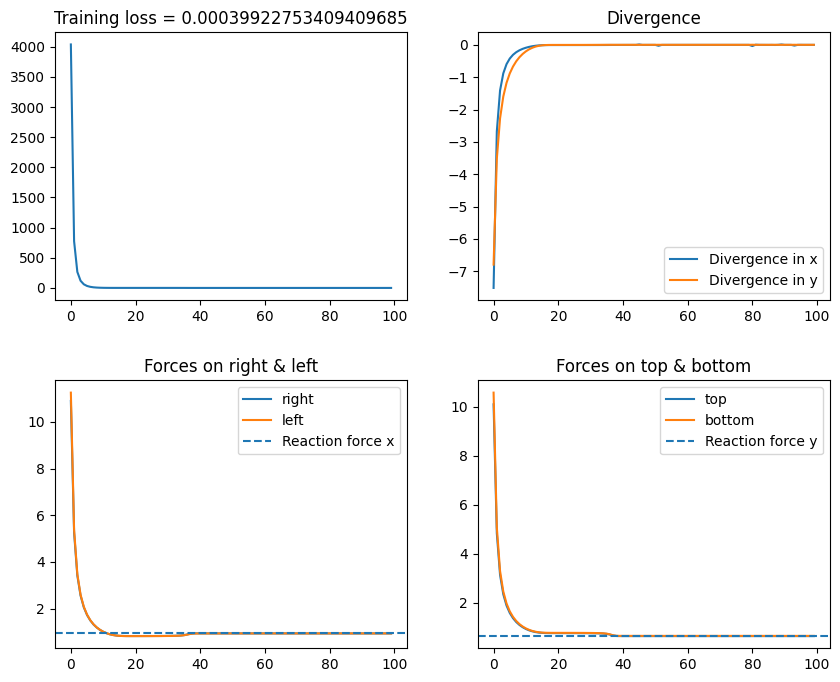

In [14]:
forces, div = np.array(metrics).T
forces = np.array([*forces])
div = np.array([*div])

fig, ax = plt.subplots(2,2,figsize=(10,8))
plt.subplots_adjust(hspace=0.3)
ax[0,0].plot(train_loss)
ax[0,1].plot(div[:,0], label='Divergence in x')
ax[0,1].plot(div[:,1], label='Divergence in y')

ax[1,0].plot(forces[:,0], label='right')
ax[1,1].plot(forces[:,1], label='top')
ax[1,0].plot(forces[:,2], label='left')
ax[1,1].plot(forces[:,3], label='bottom')

ax[1,0].axhline(Fx, linestyle='--', label='Reaction force x')
ax[1,1].axhline(Fy, linestyle='--', label='Reaction force y')

# ax[0,0].set(yscale='log')
ax[0,0].set(title='Training loss = ' + str(train_loss[-1]))
ax[0,1].set(title='Divergence')
ax[1,0].set(title='Forces on right & left')
ax[1,1].set(title='Forces on top & bottom')
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()

In [15]:
file = 'abaqus/square.inp'
with open(file) as f:
    lines = [line.rstrip('\n') for line in f]

# Get the elements (only needed for plotting the mesh)
i1 = -1
i2 = -1
for i, line in enumerate(lines):
    if line.find('*Element') >= 0:
        # get the element type
        j = line.find('=')
        elemtype = line[j+1:]
        i1 = i+1
        break


for j, line in enumerate(lines[i1:]):
    if line.find('*') >= 0:
        i2 = i1+j
        break
elems = lines[i1:i2]
elems = [line.split() for line in elems]
elems = [[a.rstrip(',') for a in line] for line in elems]
elems = np.array(elems, dtype=int)
elems = elems[:,1:]


# Get the nodes
i1 = -1
i2 = -1
for i, line in enumerate(lines): # Find the line that starts with '*Node'
    if line.find('*Node') >= 0:
        i1 = i+1
        break
for i, line in enumerate(lines): # Find the line that starts with '*Element' 
    if line.find('*Element') >= 0:
        i2 = i
        break
lines = lines[i1:i2]
lines = [line.split() for line in lines]
lines = [[a.rstrip(',') for a in line] for line in lines]
abq_node_X = np.array(lines, dtype=float)
nodes = np.array(abq_node_X[:,0],dtype=int)
abq_node_X = abq_node_X[:,1:3]

In [16]:
# Write the common parts of the Abaqus input file
with open(file, 'r') as f:
    inptxt = f.read()

# Inject the boundary loads
i1 = inptxt.find('*Cload')+7
i2 = i1 + inptxt[i1:].find(',')
setname = inptxt[i1:i2]
i2 = i1 + inptxt[i1:].find('*')
inptxt = inptxt[:i1] + setname + ', 1, ' + str(Fx) + '\n' + inptxt[i2:]

i1 = i1 + inptxt[i1:].find('*Cload') + 7
i2 = i1 + inptxt[i1:].find(',')
setname = inptxt[i1:i2]
i2 = i1 + inptxt[i1:].find('*')
inptxt = inptxt[:i1] + setname + ', 2, ' + str(Fy) + '\n' + inptxt[i2:]


# Write the heterogeneous parts of the Abaqus input file
# Find the instance name
i1 = inptxt.find('*Instance')
i1 = i1 + inptxt[i1:].find('=') + 1
i2 = i1 + inptxt[i1:].find(',')
instname = inptxt[i1:i2]

# Define node sets for each node
i = inptxt.find('*Assembly')
i = i + inptxt[i:].find('*Nset')
part1, part2 = inptxt[:i], inptxt[i:]
for node in nodes:
    part1 += "*Nset, nset=myset-" + str(node) + ", instance=" + instname + " \n " + str(node) + ",\n"
inptxt = part1+part2

# Define field variables for each node set
i = inptxt.find("** ----")
part1, part2 = inptxt[:i], inptxt[i:]
part1 += "** \n** PREDEFINED FIELDS\n** \n"
k = 1
for i in range(len(nodes)):
    node = nodes[i]
    Lambda_inp = abq_node_X[i].reshape([-1,2])
    phi = nn_fpass(Lambda_inp, Lambda_params).flatten()

    for j, param in enumerate(phi):
        part1 += "** Name: myfield-" + str(k) + "   Type: Field\n*Initial Conditions, type=FIELD, variable=" + \
            str(j+1) + "\nmyset-" + str(node) + ", " + str(jnp.exp(param)) + "\n"
        k+= 1
inptxt = part1+part2

with open('abaqus/test.inp', 'w') as f:
    f.write(inptxt)
